In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Read data

In [2]:
df = pd.read_csv('predictionsRuss2000.csv')
df = df.dropna(subset=['predict'])
df = df.drop(columns='ret')

df2 = pd.read_csv('dataRuss2000.csv',low_memory=False)
df = df.merge(df2,on=['date','ticker'],how='inner')
df['date'] = pd.to_datetime(df.date).dt.to_period('M')

predictors = ['roeQ','volume','marketcap','mom','volatility','lagret','bp','bpD']
df = df[['date','ticker','predict','industry','ret']+predictors]

## Equally weighted portfolios

In [3]:
rnks = df.groupby('date').predict.rank().values
df['portfolio'] = np.where(rnks<=50,'low','none')

rnks = df.groupby('date').predict.rank(ascending=False).values
df['portfolio'] = np.where(rnks<=50,'high',df.portfolio)

rets = df.groupby(['portfolio','date']).ret.mean()
(100*12*rets.unstack(level='portfolio').mean()).round(1)

portfolio
high    12.4
low    -17.7
none    10.8
dtype: float64

In [4]:
(100*np.sqrt(12)*rets.unstack(level='portfolio').std()).round(1)

portfolio
high    22.9
low     23.3
none    21.6
dtype: float64

## Industry holdings by month

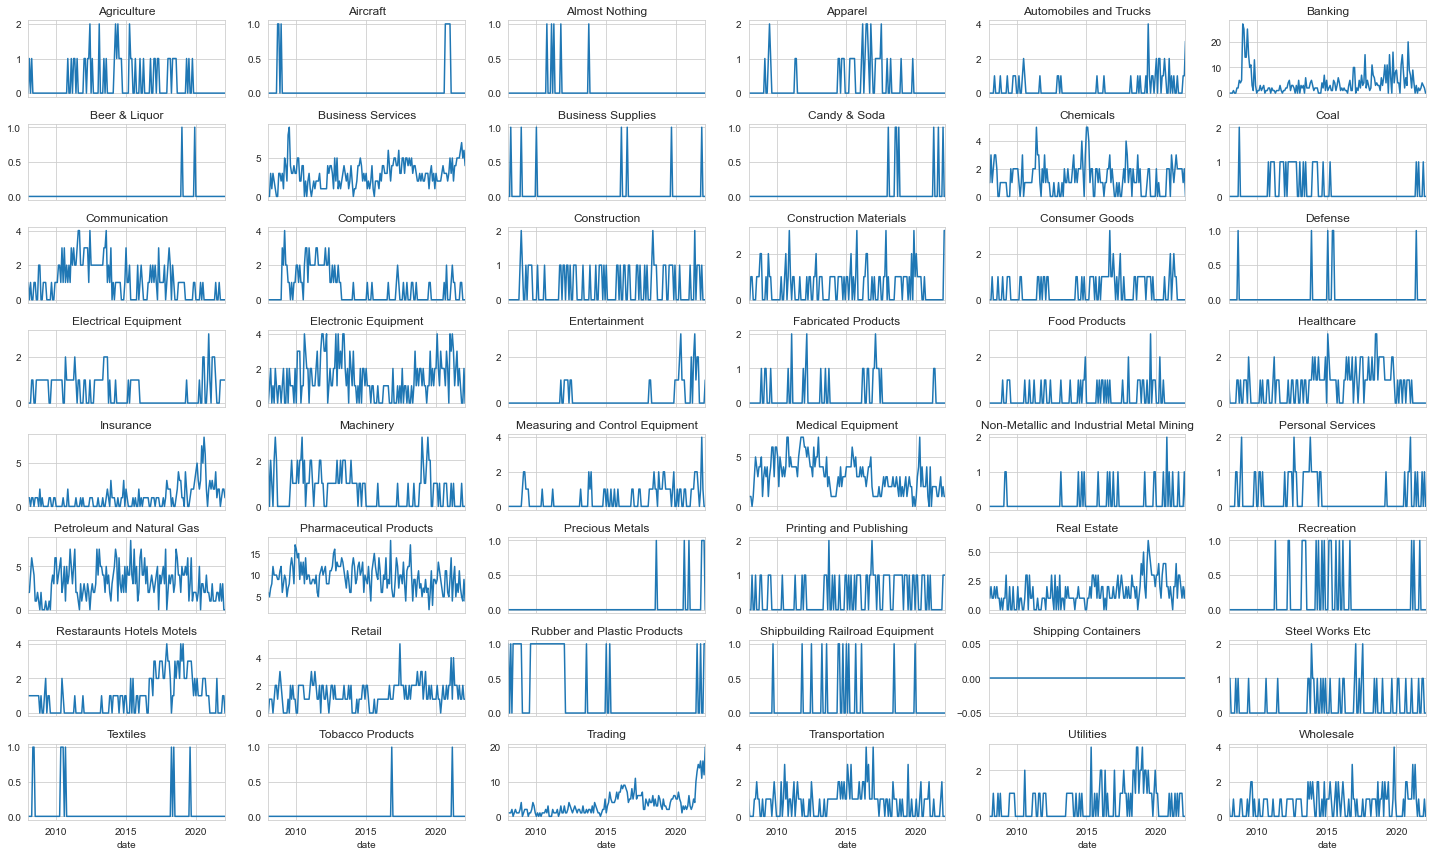

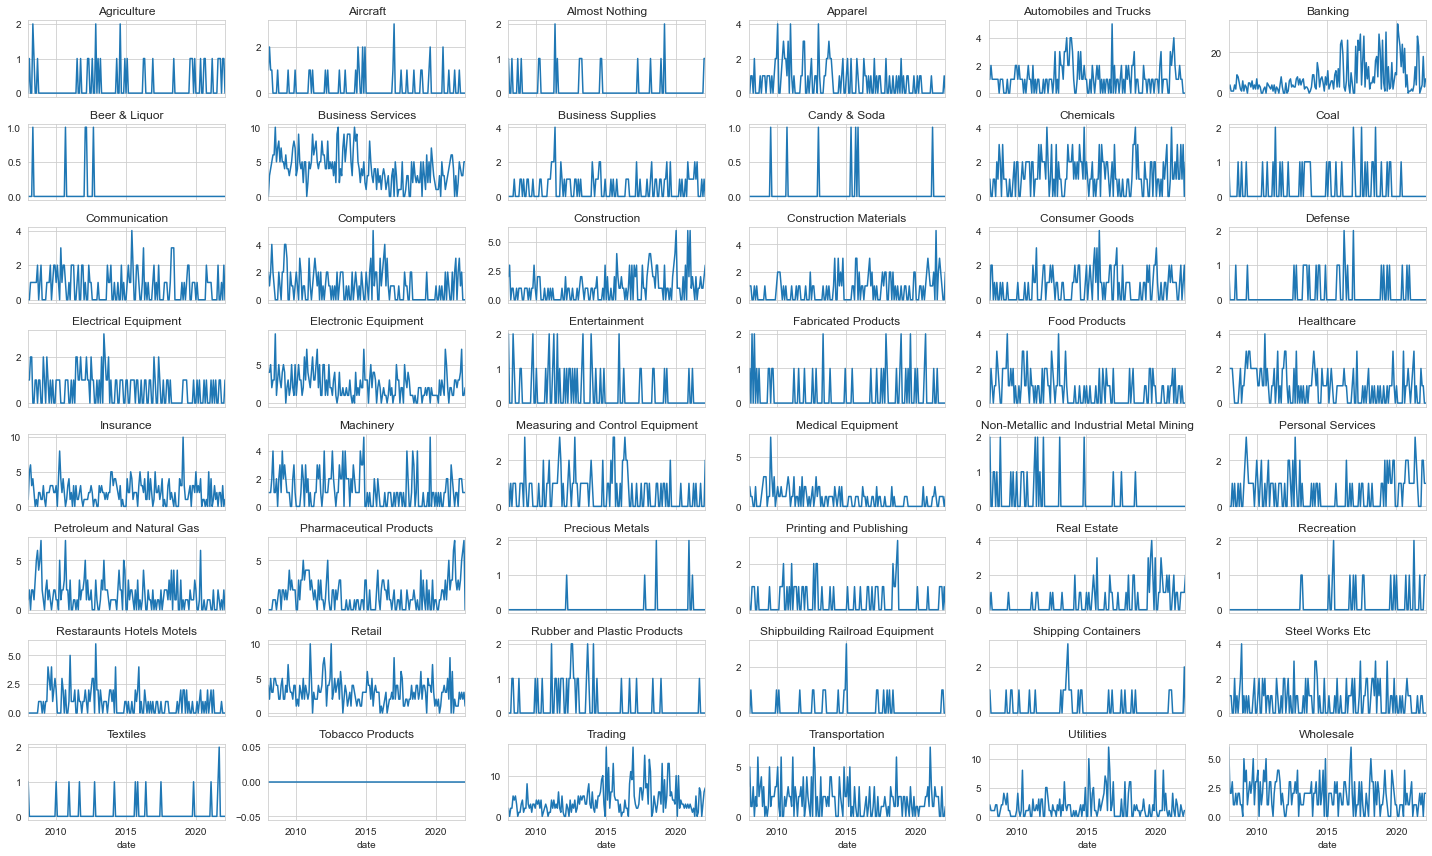

In [5]:
indx = pd.MultiIndex.from_product([('low','high'),df.industry.unique(),df.date.unique()])
num = df.groupby(['portfolio','industry','date']).ticker.count()
num = num.reindex(indx).fillna(0)
num.index.names = ['portfolio','industry','date']
num = num.sort_index(level=num.index.names)

inds = num.index.unique('industry').dropna()
figs = {}

n1=8
n2=6

for p in ['low','high'] :
    fig, axes = plt.subplots(n1,n2,sharex=True,figsize=(20,12))
    for i in range(n1) :
        for j in range(n2) :
            ax = axes[i,j]
            ind = inds[n2*i+j]
            num.loc[(p,ind)].plot(ax=ax)
            ax.set_title(ind)
    ax.set_xticks(['2010-01','2015-01','2020-01'])
    ax.set_xticklabels(['2010','2015','2020'])
    fig.tight_layout()
    fig.savefig(p+'Inds.pdf')
    figs[p] = fig

In [6]:
figs['low'].savefig('LowInds.pdf')
figs['high'].savefig('HighInds.pdf')

## Get rid of banks

In [7]:
df2 = df[df.industry!='Banking'].copy()
rnks = df2.groupby('date').predict.rank().values
df2['portfolio'] = np.where(rnks<=50,'low','none')

rnks = df2.groupby('date').predict.rank(ascending=False).values
df2['portfolio'] = np.where(rnks<=50,'high',df2.portfolio)

rets2 = df2.groupby(['portfolio','date']).ret.mean()
(100*12*rets2.unstack(level='portfolio').mean()).round(1)

portfolio
high    13.5
low    -15.6
none    11.2
dtype: float64